In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

In [110]:
class config:
   
    num_labels = 6
    n_epochs = 5
    batch_size = 128
    lr = 0.001
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [134]:
clusters=pd.read_csv('Hs_ProtBERT_rerun_umap_gmm_clusters.csv')
ids = np.load("Hs_all_train_ids.npy")
labels = clusters['gmm'].astype("category")
labels_df = pd.DataFrame(data={"EntryID":ids, "labels_vect":labels})
labels_df.to_pickle("labels.pkl")

In [145]:
ids = np.load("Hs_all_train_ids.npy")
labels = clusters['gmm']

labels_list = []
for i in range(len(labels)):
    labels_matrix = []
    for l in range(labels.nunique()):
        if labels[i]==l:
            labels_matrix.append(1)
        else:
            labels_matrix.append(0)
    labels_list.append(labels_matrix)
   
labels_df = pd.DataFrame(data={"EntryID":ids, "labels_vect":labels_list})
labels_df.to_pickle("labels.pkl")

GENERATION FINISHED!


In [146]:
labels_df.head()

,EntryID,labels_vect
0,ADNP2_HUMAN_0,"[0, 1, 0, 0, 0, 0]"
1,ADNP2_HUMAN_1,"[0, 1, 0, 0, 0, 0]"
2,ADNP2_HUMAN_2,"[0, 1, 0, 0, 0, 0]"
3,ADNP2_HUMAN_3,"[0, 0, 1, 0, 0, 0]"
4,ADNP2_HUMAN_4,"[0, 1, 0, 0, 0, 0]"


In [147]:
# Directories for the different embedding vectors : 
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeds",
    "ESM2" : "esm2-embeds"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "ESM2" : 1280
}

In [276]:
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if embeddings_source in ["ProtBERT", "ESM2"]:
            embeds = np.load("Hs_all_train_embeddings.npy")
            ids = np.load("Hs_all_train_ids.npy")
        
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if datatype=="train":
            df_labels = pd.read_pickle(
                "labels.pkl")
            self.df = self.df.merge(df_labels, on="EntryID")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [208]:
dataset = ProteinSequenceDataset(datatype="train",embeddings_source="ProtBERT")

In [209]:
embeddings, labels = dataset.__getitem__(0)
print("COMPONENTS FOR FIRST PROTEIN : ")
print("EMBEDDINGS VECTOR : \n ", embeddings, "\n")
print("TARGETS LABELS VECTOR : \n ", labels, "\n")

COMPONENTS FOR FIRST PROTEIN : 
EMBEDDINGS VECTOR : 
  tensor([ 0.0363,  0.1112,  0.0295,  ..., -0.0324,  0.0506,  0.0593]) 

TARGETS LABELS VECTOR : 
  tensor([0., 1., 0., 0., 0., 0.]) 



In [210]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1012, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [212]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):
    
    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=config.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=config.num_labels).to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)
        
        ## VALIDATION PHASE : 
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

In [277]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="ProtBERT",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|███████████████████████████████████████████| 90/90 [00:00<00:00, 90.63it/s]


Running Average TRAIN Loss :  0.8056134250428941
Running Average TRAIN F1-Score :  0.4061925240688854
Running Average VAL Loss :  0.5856729120016098
Running Average VAL F1-Score :  0.4694590836763382


EPOCH  2


100%|███████████████████████████████████████████| 90/90 [00:00<00:00, 90.06it/s]


Running Average TRAIN Loss :  0.5507391552130382
Running Average TRAIN F1-Score :  0.4962012701564365
Running Average VAL Loss :  0.48540460765361787
Running Average VAL F1-Score :  0.4995451718568802


EPOCH  3


100%|███████████████████████████████████████████| 90/90 [00:00<00:00, 90.78it/s]


Running Average TRAIN Loss :  0.49715887473689185
Running Average TRAIN F1-Score :  0.5223821596966849
Running Average VAL Loss :  0.4995282679796219
Running Average VAL F1-Score :  0.5146448612213135


EPOCH  4


100%|███████████████████████████████████████████| 90/90 [00:01<00:00, 86.81it/s]


Running Average TRAIN Loss :  0.44975917372438645
Running Average TRAIN F1-Score :  0.5375231428278817
Running Average VAL Loss :  0.4097432941198349
Running Average VAL F1-Score :  0.531940895318985


EPOCH  5


100%|███████████████████████████████████████████| 90/90 [00:01<00:00, 88.89it/s]


Running Average TRAIN Loss :  0.4037374829252561
Running Average TRAIN F1-Score :  0.5537115606996749
Running Average VAL Loss :  0.3538017928600311
Running Average VAL F1-Score :  0.5565687596797944


TRAINING FINISHED
FINAL TRAINING SCORE :  0.5537115606996749
FINAL VALIDATION SCORE :  0.5565687596797944


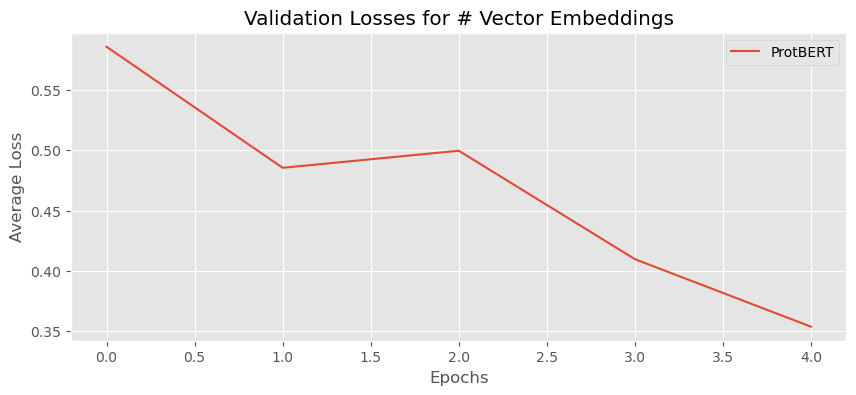

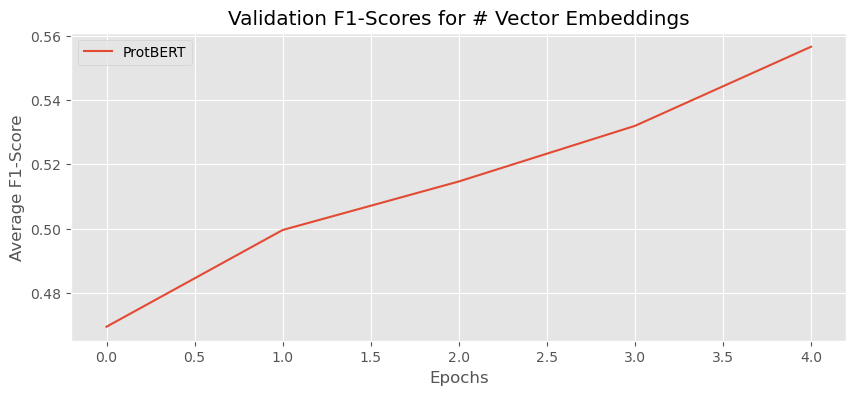

In [278]:
plt.figure(figsize = (10, 4))

plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [323]:
#Prediction dataset
class ProteinSequenceDataset(Dataset):
    
    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        
        if embeddings_source in ["ProtBERT", "EMS2"]:
            embeds = np.load("Ciona_intestinalis_all_C2H2s_train_embeddings.npy")
            ids = np.load("Ciona_intestinalis_all_C2H2s_train_ids.npy")
        
            
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if datatype=="train":
            df_labels = pd.read_pickle(
                "labels.pkl")
            self.df = self.df.merge(df_labels, on="EntryID")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [324]:
def predict(embeddings_source):
    
    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "ESM2":
        model = ems2_model
        
    model.eval()
    
    labels = clusters['gmm']
    #top_terms = labels.groupby["EntryID"].count().sort_values(ascending=False)
    labels_names = labels[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "Cluster_predict" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [325]:
submission_df = predict("ProtBERT")

GENERATE PREDICTION FOR TEST SET...


1308it [00:00, 5497.44it/s]

PREDICTIONS DONE


In [301]:
submission_df.head(50)

,Id,Cluster_predict,Confidence
0,DMD_CAEEL_0,0,0.000840
1,DMD_CAEEL_0,1,0.998071
2,DMD_CAEEL_0,2,0.213992
3,DMD_CAEEL_0,3,0.459360
4,DMD_CAEEL_0,4,0.534876
5,DMD_CAEEL_0,5,0.002442
6,DPFF1_CAEEL_0,0,0.423047
7,DPFF1_CAEEL_0,1,0.001427
8,DPFF1_CAEEL_0,2,0.784041
9,DPFF1_CAEEL_0,3,0.840451


In [327]:
submission_df.to_csv('Ciona_intestinalis_all_C2H2s_ProtBERT_linear_predict.csv', sep='\t', index=False)

In [271]:
#submission_df=pd.read_csv('clustered_C2H2_ProtBERT_linear_predict.csv', sep='\t')

In [328]:
submission_df1=submission_df.groupby('Id')['Confidence'].max()
idx = submission_df.groupby('Id')['Confidence'].transform(max) == submission_df['Confidence']
transform_df=submission_df[idx]
transform_df.to_csv('Ciona_intestinalis_all_C2H2s_ProtBERT_linear_predict_transform.csv')